In [1]:
# import all the packages

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import seaborn as sns
from scipy.integrate import quad
import math
import random
import re
from pymc3.math import log, exp, where
import pymc3 as pm
import theano.tensor as T
import itertools

In [2]:
############ NHPP DISTRIBUTION ################

class Nhpp():	
	# nhpp
	def __init__(self) -> None:
			pass

	def _get_piecewise_val(self, knots, t):
		"""
		Based on the knots specified for a piecewise linear function
		and a point in the domain 't', return the value of the piecewise
		linear function.

		knots: dictionary where keys and values should all be numeric.
		t: numeric within the domain specified by the knots.

		returns: float
		"""
		knots = {i: knots[i] for i in sorted(knots.keys())}

		knot_times = list(knots.keys())
		knot_vals = list(knots.values())

		if t < knot_times[0] or t > knot_times[-1]:
			raise ValueError(f"Cannot determine piecewise value for t={t}")

		s = []

		for i in range(1, len(knot_times)):
			s.append((knot_vals[i] - knot_vals[i-1]) / 
				(knot_times[i] - knot_times[i-1]))

		j = 0
		while knot_times[j+1] < t:
			j += 1
		return knot_vals[j] + s[j]*(t - knot_times[j])


	def _get_sorted_pairs(self, dic):
		dic = {i: dic[i] for i in sorted(dic.keys())}

		keys = list(dic.keys())
		vals = list(dic.values())
		return keys, vals

	def _get_rate_slopes(self, knot_vals, knot_times):
		"""
		Gets the slopes of each section of the rate function.

		Note that we should be o.k. against division by zero,
		but we'll raise an error just in case knot_times
		somehow gets passed in manually.
		"""
		if len(knot_times) != len(list(set(knot_times))):
			raise ValueError("Cannot infer piecewise function from knots.")
			
		return [(knot_vals[i] - knot_vals[i-1]) / 
				(knot_times[i] - knot_times[i-1]) for i in range(1, len(knot_times))]


	def _get_integrated_rate_values(self, knot_vals, knot_times):
		L = [0]
		for i in range(1, len(knot_times)):
			L.append(L[-1] + 
				0.5 * (knot_vals[i] + knot_vals[i-1]) * 
				(knot_times[i] - knot_times[i-1])
				)
		return L


	def _check_is_dict(self, a):
		if type(a) != dict:
			raise TypeError('Value passed must be a dictionary.')

	def _check_arrivals_positive(self, knot_vals):
		for val in knot_vals:
			if val < 0:
				raise ValueError


	def get_arrivals(self, knots: dict, func=None, *func_args, **func_kwargs) -> list :
		"""
		Generate a sequence from a nonhomogeneous Poisson process
		specified by a piecewise linear function determined from
		the knots parameter. The knots should specify the (domain, range)
		of each segment's knot.

		knots: dictionary where keys and values should all be numeric.
		func: function that takes a single float and returns a float.
			Note that the function must be DOMINATED by the piecewise
			linear knots, f(x) >= g(x), everywhere in the domain.

		func_args: additional args to func
		fung_kwargs: additional kwargs to func

		returns: list of floats
		"""
		self._check_is_dict(knots)

		knot_times, knot_vals = self._get_sorted_pairs(knots)

		self._check_arrivals_positive(knot_vals)

		def _inv_int_rate_func(u, j):
			"""
			Inner function defined here due to its dependence
			on the specific knots. Calculates the inverted
			INTEGRATED rate function.
			"""
			res = 0
			if s[j] != 0:
				res = knot_times[j] + 2 * (u - L[j]) / (
					knot_vals[j] + np.sqrt(
						knot_vals[j]**2 + 2 * s[j] * (u - L[j])
						)
					)
			else: # Case when slope of rate is 0
				res = knot_times[j] + (u - L[j]) / knot_vals[j]
			return res

		s = self._get_rate_slopes(knot_vals, knot_times)
		L = self._get_integrated_rate_values(knot_vals, knot_times)

		a = [0] # Arrival times for nonhomogeneous poisson process
		u = [0] # Arrival times for homogeneous poisson process 
		j = 0   # Counter to see which 'piece' of the integrated rate function we are in.

		while True:
			u_next = u[-1] + np.random.exponential(1.0)
			if u_next >= L[-1]:
				break
			while L[j+1] < u_next and j < len(knot_times):
				j += 1
			a_next = _inv_int_rate_func(u_next, j)
			
			if func:
				# In this branch we reject a_next if an independently
				# drawn uniform RV falls out of our acceptance region,
				# i.e., the ratio of the smooth function and the
				# piecewise approx.

				ind_unif = np.random.uniform(0,1)
				prob_ratio = func(a_next, *func_args, **func_kwargs) / self._get_piecewise_val(knots, a_next)
				#if prob_ratio > 1:
					#raise ValueError('Piecewise function does not dominate smooth function.')
				if ind_unif < prob_ratio:
					a.append(a_next)
				u.append(u_next)

			else:
				a.append(a_next)
				u.append(u_next)
		return a[1:]

**Paper motivation**

In [3]:
class Model():
    def __init__(self) -> None:
        self.etas = []
        self.nhpp = Nhpp()  # object for non-homogenuous process
        self.init_stock_number=[]
        self.transactions = [0, 0, 0]  # transaction per item number
        self.transactions_times = [[], [], []]  # transaction time per item
        self.items_list = [1, 2, 3]
        self.preferenced_lists = [[1], [2], [3], [1, 2], [1, 3], [2, 1], [2, 3], [3, 1], [3, 2]]
        self.no_purchase_num = [0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.no_pref_item_num = [0, 0, 0, 0, 0, 0, 0, 0, 0]     
        self.customer_segments_num = 9
        self.time = 1000

    def get_etas(self):
        n1 = [2000, 4000]
        n2 = [2, 4]
        n3 = [200, 400]

        for n in [n1, n2, n3]:
            self.etas.append(np.random.uniform(n[0], n[1], size=self.time))

        # take the mean of each eta, should match the data from the paper
        self.eta1 = np.mean(self.etas[0])
        self.eta2 = np.mean(self.etas[1])
        self.eta3 = np.mean(self.etas[2])

    # function for getting lambda
    def get_lambda(self, t):
        lambda1 = self.eta1 * (self.eta2 / self.eta3) * (t/self.eta3)**(self.eta2-1) * (1 + (t/self.eta3)**self.eta2)**-2
        return lambda1

    def get_list_of_lambdas(self):
        hill_rate_lambda = []
        for t in range(0, self.time):
            l = self.get_lambda(t)
            hill_rate_lambda.append(l)
        return hill_rate_lambda

    def format_lambdas(self):
        list_of_lambdas = self.get_list_of_lambdas()
        dict_lambdas = dict()
        for i in range(len(list_of_lambdas)):
            dict_lambdas[i] = list_of_lambdas[i]
        return dict_lambdas

    def define_time_purchases(self, times, l):
        self.init_stock_number.append([1000,1000,1000])
        for arrival in times:
            ki = random.SystemRandom().choice([0,3,8])
            _, _ = self.purchase(self.preferenced_lists[ki][0], ki, arrival, l)
        return self.transactions_times

    def get_arrival_times(self):
        lambdas_dict = self.format_lambdas()
        arrival_times = self.nhpp.get_arrivals(lambdas_dict, self.get_lambda)
        return arrival_times

    
    def stock_indicator(self, elem, l):  # s(t)
        if self.transactions[elem] >= self.init_stock_number[l][elem]:
            return 0
        else:
            return 1

    def purchase(self, item, customer_segment, arrival_time, l):  # customer segment
        purchase_item = min(self.preferenced_lists[customer_segment], key=lambda el: self.stock_indicator(self.items_list.index(el), l) == 0)
        if self.stock_indicator(self.items_list.index(purchase_item), l):
            self.transactions_times[self.items_list.index(purchase_item)].append(arrival_time)
            self.transactions[self.items_list.index(purchase_item)] += 1
            if purchase_item == item:
                return 1, True
            else:
                self.no_pref_item_num[customer_segment] += 1
                return 0, True
        else:
            self.no_purchase_num[customer_segment] += 1
            return 0, False

In [11]:
model1 = Model()
model1.get_etas()
arrivals_per_time_period = []
times = model1.get_arrival_times()
print("Number of arrivals: ", len(times))
arrivals_per_time_period.append(times)
transactions = model1.define_time_purchases(arrivals_per_time_period[0], 0)
print("Customer segments` lists: ", model1.preferenced_lists[0],model1.preferenced_lists[3], model1.preferenced_lists[8])
print("Initial number in stock: ", model1.init_stock_number)
print("Transactions: ", model1.transactions)
print("No purchase: ", model1.no_purchase_num, "\nNo preferred item:", model1.no_pref_item_num)

Number of arrivals:  2916
Customer segments` lists:  [1] [1, 2] [3, 2]
Initial number in stock:  [[1000, 1000, 1000]]
Transactions:  [1000, 464, 963]
No purchase:  [489, 0, 0, 0, 0, 0, 0, 0, 0] 
No preferred item: [0, 0, 0, 464, 0, 0, 0, 0, 0]


**GENERATED DATA**

In [ ]:
################### MODEL ########################

class Model():
    def __init__(self) -> None:
        self.etas = []
        self.nhpp = Nhpp()  # object for non-homogenuous process
        self.transactions_times = [[], [], []]  # transaction time per item
        self.customer_segments_num = 3
        self.time = 1000
        init_stock_number_per_l = []
        self.init_stock_number = []
        for i in range(2):
          init_stock_number_per_l.clear()
          st = int(np.random.uniform(0, 500))
          init_stock_number_per_l.append(st)
          st = int(np.random.uniform(0, 500))
          init_stock_number_per_l.append(st)
          st = int(np.random.uniform(0, 500))
          init_stock_number_per_l.append(st)
          self.init_stock_number.append(init_stock_number_per_l)
    def get_etas(self):
        n1 = [2000, 4000]
        n2 = [2, 4]
        n3 = [200, 400]

        for n in [n1, n2, n3]:
            self.etas.append(np.random.uniform(n[0], n[1], size=self.time))

        # take the mean of each eta, should match the data from the paper
        self.eta1 = np.mean(self.etas[0])
        self.eta2 = np.mean(self.etas[1])
        self.eta3 = np.mean(self.etas[2])


    def get_lambda(self, t):
        lambda1 = self.eta1 * (self.eta2 / self.eta3) * (t/self.eta3)**(self.eta2-1) * (1 + (t/self.eta3)**self.eta2)**-2
        return lambda1

    def get_list_of_lambdas(self):
        hill_rate_lambda = []
        for t in range(0, self.time):
            l = self.get_lambda(t)
            hill_rate_lambda.append(l)
        return hill_rate_lambda

    def format_lambdas(self):
        list_of_lambdas = self.get_list_of_lambdas()
        dict_lambdas = dict()
        for i in range(len(list_of_lambdas)):
            dict_lambdas[i] = list_of_lambdas[i]
        return dict_lambdas

    
    def get_arrival_times(self):
        lambdas_dict = self.format_lambdas()
        arrival_times = self.nhpp.get_arrivals(lambdas_dict, self.get_lambda)
        return arrival_times

    def define_time_purchases(self, times, l):
        for arrival in times:
            ki = random.randint(0,2)
            if self.init_stock_number[l][ki] != 0:
                self.transactions_times[ki].append(arrival)
                self.init_stock_number[l][ki] -= 1
            else:
                pass
        return self.transactions_times        

In [ ]:
############### GET ARRIVAL TIMES ###################
model1 = Model()
model1.get_etas()
arrivals_per_time_period = []
time_period = 2
for l in range(time_period):    
    times = model1.get_arrival_times()
    arrivals_per_time_period.append(times)
# GET TRANS TIMES PER ITEM
transactions_generated = []
for l in range(time_period):
    transactions = model1.define_time_purchases(arrivals_per_time_period[l], l)
    transactions_generated.append(transactions)

In [ ]:
################# MCMC ########################

time = 1000
transactions_times = transactions_generated
our_model = pm.Model()
k = 3
with our_model:
    
    # Priors for r and alpha, to get our lambdas
    eta1 = pm.Uniform("eta1", 2000, 4000)
    eta2 = pm.Uniform("eta2", 2, 4)
    eta3 = pm.Uniform("eta3", 200, 400)
    theta = pm.Dirichlet("Thetas", a=np.ones(k))
    def get_lambda(t):
        lambda1 = eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2
        return lambda1
    def get_purchase_rate(item, arrival_time,l):  # lambda * п\
        # arrival_time = arrival_time.eval()
        if int(arrival_time) <= transactions_times[l][item][-1]:
            purchase_rate = get_lambda(int(arrival_time)) * theta
        else:
            purchase_rate = 0
        return purchase_rate
    
    def get_integral_mean_rate(t, item,l):
        if t <= transactions_times[l][item][-1]:
            lambda1 = (eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2) * theta
        else:
            lambda1 = 0
        return lambda1

    def get_mean_purchase_rate(item,l):
        mean_purchase_rate = 0
        for i in range(time):
            mean_purchase_rate = mean_purchase_rate + get_integral_mean_rate( i, item,l)
        return mean_purchase_rate
    
    def likelihood_model(time_period, items_num):
        result = 0
        x = time_period.eval()
        y = items_num.eval()
        for l in range(int(x)):
            print(l)
            df_transactions = pd.DataFrame((_ for _ in itertools.zip_longest(*transactions_generated[l])), columns=['cookie1', 'cookie2', 'cookie3'])
            df_transactions.fillna(0,inplace=True)
            cookie1_purchases = df_transactions.iloc[0].values
            cookie2_purchases = df_transactions.iloc[1].values
            cookie3_purchases = df_transactions.iloc[2].values
            times_per_item = [list(cookie1_purchases), list(cookie2_purchases), list(cookie3_purchases)]

            for i in range(int(y)):  # number of items
                result_m = 0
                # number of purchases of each item
                for j in range(len(times_per_item[i])):
                    purchase_rate = get_purchase_rate(i, times_per_item[i][j],l)
                    if (purchase_rate != 0):
                        result_m += np.log(purchase_rate)
                mean_purchase_rate = get_mean_purchase_rate(i,l)
                result = result + result_m - mean_purchase_rate
        return result
        
    loglikelihood = pm.DensityDist("loglikelihood", likelihood_model, observed={ 'time_period': 2, 'items_num':3})

with our_model:
    trace = pm.sample(tune=10, draws=100, return_inferencedata=True)


0
1
0
1
0
1


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [Thetas, eta3, eta2, eta1]


Sampling 2 chains for 10 tune and 100 draw iterations (20 + 200 draws total) took 45 seconds.
The acceptance probability does not match the target. It is 0.976725300360914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9744664599762197, but should be close to 0.8. Try to increase the number of tuning steps.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


<Figure size 504x504 with 0 Axes>

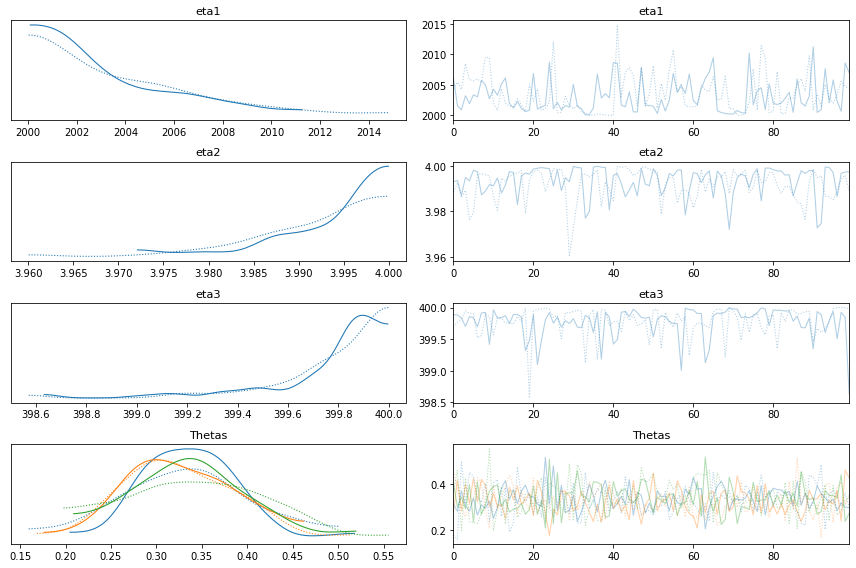

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

**EMPIRICAL DATA**

In [ ]:
################# GET EMPIRICAL DATA ########################

def insert_row(row_number, df, row_value):
    start_upper = 0
    end_upper = row_number
    start_lower = row_number
    end_lower = df.shape[0]
    upper_half = [*range(start_upper, end_upper, 1)]
    lower_half = [*range(start_lower, end_lower, 1)]
    lower_half = [x.__add__(1) for x in lower_half]
    index_ = upper_half + lower_half
    df.index = index_
    df.loc[row_number] = row_value
    df = df.sort_index()
    return df
url = 'https://github.com/jane1357z/cookies/blob/dcdf00b8b50d5a26193d3b18fdcabc761b669fd8/chocolate_chip_cookie_transactions.csv?raw=true'
from_excel1 = pd.read_csv(url, sep=',', header=0, engine='python')
dates = from_excel1.date.unique()
dates1=dates

url = 'https://github.com/jane1357z/cookies/blob/dcdf00b8b50d5a26193d3b18fdcabc761b669fd8/double_chocolate_cookie_transactions.csv?raw=true'
from_excel2 = pd.read_csv(url, sep=',', header=0, engine='python')
dates = from_excel2.date.unique()
dates2=dates

url = 'https://github.com/jane1357z/cookies/blob/dcdf00b8b50d5a26193d3b18fdcabc761b669fd8/oatmeal_cookie_transactions.csv?raw=true'
from_excel3 = pd.read_csv(url, sep=',', header=0, engine='python')
dates = from_excel3.date.unique()
dates3=dates

diff2 = set(dates1).difference(set(dates2))
diff3 = set(dates1).difference(set(dates3))

for i in range(len(dates1)):
    if dates1[i] in diff2:
        if i == 0:
            row_value = [dates1[i],"zero"]
            from_excel2 = insert_row(0, from_excel2, row_value)
        else:
            ind = from_excel2[from_excel2.date == dates1[i-1]].index.values.astype(int)
            row = ind[-1] + 1
            row_value = [dates1[i],"zero"]
            from_excel2 = insert_row(row, from_excel2, row_value)
for i in range(len(dates1)):
    if dates1[i] in diff3:
        if i == 0:
            row_value = [dates1[i],"zero"]
            from_excel3 = insert_row(0, from_excel3, row_value)
        else:
            ind = from_excel3[from_excel3.date == dates1[i-1]].index.values.astype(int)
            row = ind[-1] + 1
            row_value = [dates1[i],"zero"]
            from_excel3 = insert_row(row, from_excel3, row_value)

for i in range(len(dates1)):
    from_excel1.loc[(from_excel1.date == dates1[i]), 'date'] = i
times = []
date_times = []
for j in range(len(from_excel1)):
    x = from_excel1.loc[j][1]
    hour = int(re.findall(r'[+-]?\d+(?:\.\d+)?', x)[0])
    if("PM" in x):
        if(hour != 12):
            hour = hour + 12
    if(hour >= 11 and hour <= 19):
        times.append(x)
        date_times.append(from_excel1.loc[j][0])
trans_data = []
for i in range(len(dates1)):
    period = []
    for j in range(len(date_times)):
        if(date_times[j] == i):
            period.append(times[j])
    trans_data.append(period)
for i in range(len(trans_data)):
    for j in range(len(trans_data[i])):
        x = trans_data[i][j]
        hour_minute = re.findall(r'[+-]?\d+(?:\.\d+)?', x)
        hour = int(hour_minute[0])
        minute = int(hour_minute[1])
        if("PM" in x):
            if(hour != 12):
                hour = hour + 12
        emp_time = (hour - 11)*60 + minute
        trans_data[i][j] = emp_time
chocolate_chip = trans_data

for i in range(len(dates1)):
    from_excel2.loc[(from_excel2.date == dates1[i]), 'date'] = i    
times = []
date_times = []
for j in range(len(from_excel2)):
    x = from_excel2.loc[j][1]
    if x =='zero':
        times.append(x)
        date_times.append(from_excel2.loc[j][0])
    else:    
        hour = int(re.findall(r'[+-]?\d+(?:\.\d+)?', x)[0])

        if("PM" in x):
            if(hour != 12):
                hour = hour + 12
        if(hour >= 11 and hour <= 19):
            times.append(x)
            date_times.append(from_excel2.loc[j][0])
trans_data = []
for i in range(len(dates1)):
    period = []
    for j in range(len(date_times)):
        if(date_times[j] == i):
            period.append(times[j])
    trans_data.append(period)
for i in range(len(trans_data)):
    for j in range(len(trans_data[i])):
        x = trans_data[i][j]
        if x == 'zero':
            trans_data[i][j] = []
        else:
            hour_minute = re.findall(r'[+-]?\d+(?:\.\d+)?', x)
            hour = int(hour_minute[0])
            minute = int(hour_minute[1])
            if("PM" in x):
                if(hour != 12):
                    hour = hour + 12
            emp_time = (hour - 11)*60 + minute
            trans_data[i][j] = emp_time
for i in range(len(trans_data)):
    if trans_data[i] == [[]]:
        trans_data[i] = []
double_chocolate = trans_data

for i in range(len(dates1)):
    from_excel3.loc[(from_excel3.date == dates1[i]), 'date'] = i    
times = []
date_times = []
for j in range(len(from_excel3)):
    x = from_excel3.loc[j][1]
    if x =='zero':
        times.append(x)
        date_times.append(from_excel3.loc[j][0])
    else:    
        hour = int(re.findall(r'[+-]?\d+(?:\.\d+)?', x)[0])
        if("PM" in x):
            if(hour != 12):
                hour = hour + 12
        if(hour >= 11 and hour <= 19):
            times.append(x)
            date_times.append(from_excel3.loc[j][0])
trans_data = []
for i in range(len(dates1)):
    period = []
    for j in range(len(date_times)):
        if(date_times[j] == i):
            period.append(times[j])
    trans_data.append(period)
for i in range(len(trans_data)):
    for j in range(len(trans_data[i])):
        x = trans_data[i][j]
        if x == 'zero':
            trans_data[i][j] = []
        else:
            hour_minute = re.findall(r'[+-]?\d+(?:\.\d+)?', x)
            hour = int(hour_minute[0])
            minute = int(hour_minute[1])
            if("PM" in x):
                if(hour != 12):
                    hour = hour + 12
            emp_time = (hour - 11)*60 + minute
            trans_data[i][j] = emp_time
for i in range(len(trans_data)):
    if trans_data[i] == [[]]:
        trans_data[i] = []
oatmeal_cookie = trans_data

empirical_data = []
time_periods_case = 151
for l in range(time_periods_case):
    empirical_data.append([chocolate_chip[l], double_chocolate[l], oatmeal_cookie[l]])
emp_data_no_empty = []
for i in range(len(empirical_data)):
    if empirical_data[i][0] and empirical_data[i][1] and empirical_data[i][2]:
        emp_data_no_empty.append([empirical_data[i][0], empirical_data[i][1], empirical_data[i][2]])

In [ ]:
final_emp = []
for i in range(len(emp_data_no_empty)):
    if len(emp_data_no_empty[i][0])>=6 and len(emp_data_no_empty[i][1])>=6 and len(emp_data_no_empty[i][2])>=6:
        final_emp.append([emp_data_no_empty[i][0], emp_data_no_empty[i][1], emp_data_no_empty[i][2]])
x = []
y = []
z = []
for i in range(len(final_emp)):
    x = x + final_emp[i][0]
    y = y + final_emp[i][1]
    z = z + final_emp[i][2]
x.sort()
y.sort()
z.sort()
x=list(set(x))
y=list(set(y))
z=list(set(z))
finalll = []
finalll.append([x,y,z])

transactions_generated = finalll

In [ ]:
################# MCMC ########################

time = 480
transactions_times = transactions_generated
our_model = pm.Model()
k = 3
with our_model:
    
    # Priors for r and alpha, to get our lambdas
    eta1 = pm.Uniform("eta1", 2000, 4000)
    eta2 = pm.Uniform("eta2", 2, 4)
    eta3 = pm.Uniform("eta3", 200, 400)
    theta = pm.Dirichlet("Thetas", a=np.ones(k))

    def get_lambda(t):
        lambda1 = eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2
        return lambda1
    def get_purchase_rate(item, arrival_time,l):  # lambda * п\
        # arrival_time = arrival_time.eval()
        if int(arrival_time) <= transactions_times[l][item][-1]:
            purchase_rate = get_lambda(int(arrival_time)) * theta
        else:
            purchase_rate = 0
        return purchase_rate
    
    def get_integral_mean_rate(t, item,l):
        if t <= transactions_times[l][item][-1]:
            lambda1 = (eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2) * theta
        else:
            lambda1 = 0
        return lambda1

    def get_mean_purchase_rate(item,l):
        mean_purchase_rate = 0
        for i in range(time):
            mean_purchase_rate = mean_purchase_rate + get_integral_mean_rate( i, item,l)
        return mean_purchase_rate
    
    def likelihood_model(time_period, items_num):
        result = 0
        x = time_period.eval()
        y = items_num.eval()
        for l in range(int(x)):
            print(l)
            df_transactions = pd.DataFrame((_ for _ in itertools.zip_longest(*transactions_generated[l])), columns=['cookie1', 'cookie2', 'cookie3'])
            df_transactions.fillna(0,inplace=True)
            cookie1_purchases = df_transactions.iloc[0].values
            cookie2_purchases = df_transactions.iloc[1].values
            cookie3_purchases = df_transactions.iloc[2].values
            times_per_item = [list(cookie1_purchases), list(cookie2_purchases), list(cookie3_purchases)]

            for i in range(int(y)):  # number of items
                result_m = 0
                # number of purchases of each item
                for j in range(len(times_per_item[i])):
                    purchase_rate = get_purchase_rate(i, times_per_item[i][j],l)
                    if (purchase_rate != 0):
                        result_m += np.log(purchase_rate)
                mean_purchase_rate = get_mean_purchase_rate(i,l)
                result = result + result_m - mean_purchase_rate
        return result
        
    loglikelihood = pm.DensityDist("loglikelihood", likelihood_model, observed={ 'time_period': 1, 'items_num':3})

with our_model:
    trace = pm.sample(tune=1000, draws=10000, return_inferencedata=True)

0
0
0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [Thetas, eta3, eta2, eta1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 3226 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


<Figure size 504x504 with 0 Axes>

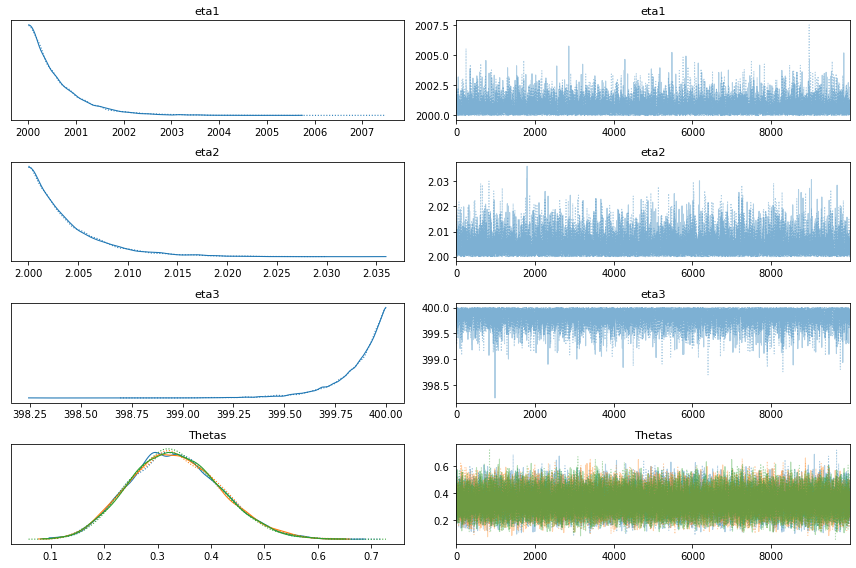

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

**CONTRIBUTION**

In [ ]:
################### MODEL ########################


class Model():
    def __init__(self) -> None:
        self.etas = []
        self.nhpp = Nhpp()  # object for non-homogenuous process
        self.transactions_times = [[], [], []]  # transaction time per item
        self.customer_segments_num = 3
        self.time = 1000
        init_stock_number_per_l = []
        self.init_stock_number = []
        for i in range(5):
          init_stock_number_per_l.clear()
          st = int(np.random.uniform(1000, 2000))
          init_stock_number_per_l.append(st)
          st = int(np.random.uniform(1000, 2000))
          init_stock_number_per_l.append(st)
          st = int(np.random.uniform(1000, 2000))
          init_stock_number_per_l.append(st)
          self.init_stock_number.append(init_stock_number_per_l)
    def get_etas(self):
        n1 = [2000, 4000]
        n2 = [2, 4]
        n3 = [200, 400]

        for n in [n1, n2, n3]:
            self.etas.append(np.random.uniform(n[0], n[1], size=self.time))

        # take the mean of each eta, should match the data from the paper
        self.eta1 = np.mean(self.etas[0])
        self.eta2 = np.mean(self.etas[1])
        self.eta3 = np.mean(self.etas[2])


    def get_lambda(self, t):
        lambda1 = self.eta1 * (self.eta2 / self.eta3) * (t/self.eta3)**(self.eta2-1) * (1 + (t/self.eta3)**self.eta2)**-2
        return lambda1

    def get_list_of_lambdas(self):
        hill_rate_lambda = []
        for t in range(0, self.time):
            l = self.get_lambda(t)
            hill_rate_lambda.append(l)
        return hill_rate_lambda

    def format_lambdas(self):
        list_of_lambdas = self.get_list_of_lambdas()
        dict_lambdas = dict()
        for i in range(len(list_of_lambdas)):
            dict_lambdas[i] = list_of_lambdas[i]
        return dict_lambdas

    
    def get_arrival_times(self):
        lambdas_dict = self.format_lambdas()
        arrival_times = self.nhpp.get_arrivals(lambdas_dict, self.get_lambda)
        return arrival_times

    def define_time_purchases(self, times, l, pois_lam):
        to_buy = np.random.poisson(3, pois_lam)
        it = 0
        for arrival in times:
            ki = random.randint(0,2)
            for _ in range(to_buy[it]):
                if self.init_stock_number[l][ki] != 0:
                    self.transactions_times[ki].append(arrival)
                    self.init_stock_number[l][ki] -= 1
                else:
                    pass
                it += 1
        return self.transactions_times

In [ ]:
############### GET ARRIVAL TIMES ###################

model1 = Model()
model1.get_etas()
arrivals_per_time_period = []
time_period = 5
pois_size = []
for l in range(time_period):    
    times = model1.get_arrival_times()
    arrivals_per_time_period.append(times)
    pois_size.append(len(times))
# GET TRANS TIMES PER ITEM
transactions_generated = []
for l in range(time_period):
    transactions = model1.define_time_purchases(arrivals_per_time_period[l], l, pois_size[l])
    transactions_generated.append(transactions)



In [ ]:
################# MCMC ########################

time = 1000
transactions_times = transactions_generated
our_model = pm.Model()
k = 3

with our_model:
    
    # Priors for r and alpha, to get our lambdas
    eta1 = pm.Uniform("eta1", 2000, 4000)
    eta2 = pm.Uniform("eta2", 2, 4)
    eta3 = pm.Uniform("eta3", 200, 400)
    theta = pm.Dirichlet("Thetas", a=np.ones(k))

    def get_lambda(t):
        lambda1 = eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2
        return lambda1
    def get_purchase_rate(item, arrival_time,l):  # lambda * п\
        # arrival_time = arrival_time.eval()
        if int(arrival_time) <= transactions_times[l][item][-1]:
            purchase_rate = get_lambda(int(arrival_time)) * theta
        else:
            purchase_rate = 0
        return purchase_rate
    
    def get_integral_mean_rate(t, item,l):
        if t <= transactions_times[l][item][-1]:
            lambda1 = (eta1 * (eta2 / eta3) * (t/eta3)**(eta2-1) * (1 + (t/eta3)**eta2)**-2) * theta
        else:
            lambda1 = 0
        return lambda1

    def get_mean_purchase_rate(item,l):
        mean_purchase_rate = 0
        for i in range(time):
            mean_purchase_rate = mean_purchase_rate + get_integral_mean_rate( i, item,l)
        return mean_purchase_rate
    
    def likelihood_model(time_period, items_num):
        result = 0
        x = time_period.eval()
        y = items_num.eval()
        for l in range(int(x)):
            print(l)
            df_transactions = pd.DataFrame((_ for _ in itertools.zip_longest(*transactions_generated[l])), columns=['cookie1', 'cookie2', 'cookie3'])
            df_transactions.fillna(0,inplace=True)
            cookie1_purchases = df_transactions.iloc[0].values
            cookie2_purchases = df_transactions.iloc[1].values
            cookie3_purchases = df_transactions.iloc[2].values
            times_per_item = [list(cookie1_purchases), list(cookie2_purchases), list(cookie3_purchases)]

            for i in range(int(y)):  # number of items
                result_m = 0
                # number of purchases of each item
                for j in range(len(times_per_item[i])):
                    purchase_rate = get_purchase_rate(i, times_per_item[i][j],l)
                    if (purchase_rate != 0):
                        result_m += np.log(purchase_rate)
                mean_purchase_rate = get_mean_purchase_rate(i,l)
                result = result + result_m - mean_purchase_rate
        return result
        
    loglikelihood = pm.DensityDist("loglikelihood", likelihood_model, observed={ 'time_period': 5, 'items_num':3})

with our_model:
    trace = pm.sample(tune=1000, draws=10000, return_inferencedata=True)


0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.7/dist-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Sequential sampling (2 chains in 1 job)
NUTS: [Thetas, eta3, eta2, eta1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 113 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


<Figure size 504x504 with 0 Axes>

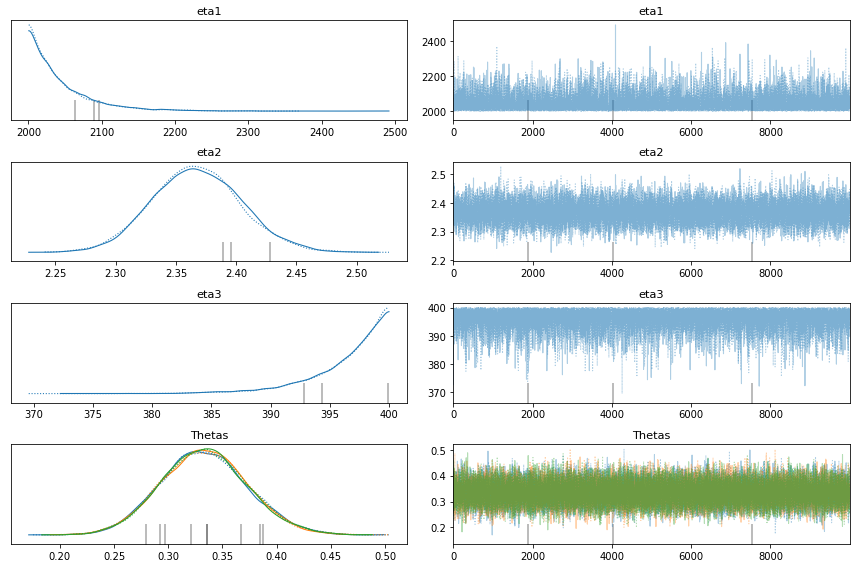

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()